In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/COVID_ПО

/content/drive/MyDrive/COVID_ПО


In [ ]:
pip install --user -r requirements.txt

In [3]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import logging
from sklearn.utils import shuffle

import tensorflow as tf

tf.get_logger().setLevel(logging.ERROR)

from tensorflow.keras.callbacks import ModelCheckpoint

from src.segmentation.image import Preprocessor
from src.segmentation.model import (
    CosineAnnealingLearningRateSchedule,
    SegmentationModel,
)
from src.utils import (Const, Estimator)

# 1. Loading data

In [4]:
def load_samples(folder_path):
    samples = []

    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        file_paths = os.listdir(folder_path)
        for i in tqdm.trange(len(file_paths)):
            path = os.path.join(folder_path, file_paths[i])
            sample = cv2.imread(path, cv2.IMREAD_GRAYSCALE) / 255.
            samples.append(sample.reshape(Const.IMG_SIZE, Const.IMG_SIZE, 1))

    return np.array(samples)

In [5]:
imgs_ct = load_samples(Const.CT_IMAGES_PATH)
imgs_lungs = load_samples(Const.LUNGS_IMAGES_PATH)
imgs_covid = load_samples(Const.COVID_IMAGES_PATH)

100%|██████████| 1614/1614 [00:19<00:00, 83.61it/s] 


In [6]:
print(f'{imgs_ct.shape}')
print(f'{imgs_lungs.shape}')
print(f'{imgs_covid.shape}')

print(f'{imgs_ct.min()} {imgs_ct.max()}')
print(f'{imgs_lungs.min()} {imgs_lungs.max()}')
print(f'{imgs_covid.min()} {imgs_covid.max()}')

(1614, 256, 256, 1)
(1614, 256, 256, 1)
(1614, 256, 256, 1)
0.0 1.0
0.0 1.0
0.0 1.0


## Shuffle the data

In [7]:
imgs_ct, imgs_lungs, imgs_covid = shuffle(imgs_ct, imgs_lungs, imgs_covid)

# 2. Splitting data into training and validation sets

In [8]:
TRAIN_SIZE = int(0.8 * imgs_ct.shape[0])
TEST_SIZE = int(0.1 * imgs_ct.shape[0])

train_x, train_lungs, train_covid = (
    imgs_ct[:TRAIN_SIZE],
    imgs_lungs[:TRAIN_SIZE],
    imgs_covid[:TRAIN_SIZE],
)
valid_x, valid_lungs, valid_covid = (
    imgs_ct[TRAIN_SIZE:],
    imgs_lungs[TRAIN_SIZE:],
    imgs_covid[TRAIN_SIZE:],
)
test_x, test_lungs, test_covid = (
    imgs_ct[:TEST_SIZE],
    imgs_lungs[:TEST_SIZE],
    imgs_covid[:TEST_SIZE],
)

print(f'{train_x.shape}, {train_lungs.shape}, {train_covid.shape}')
print(f'{valid_x.shape}, {valid_lungs.shape}, {valid_covid.shape}')
print(f'{test_x.shape}, {test_lungs.shape}, {test_covid.shape}')

del imgs_ct, imgs_lungs, imgs_covid
del TRAIN_SIZE, TEST_SIZE

(1291, 256, 256, 1), (1291, 256, 256, 1), (1291, 256, 256, 1)
(323, 256, 256, 1), (323, 256, 256, 1), (323, 256, 256, 1)
(161, 256, 256, 1), (161, 256, 256, 1), (161, 256, 256, 1)


# 3. Train Model

We will use dice coefficient as a metric for infection segmentation.
Dice coefficient is

$$\frac{2 TP}{2 TP+FN+FP}$$

where $TP$, $FN$ and $FP$ correspond to true positive, false negative and false positive.

In [9]:
EPOCHS = 50
BATCH_SIZE = 16
FROM_SCRATCH = True

In [10]:
lungs_segmentation = SegmentationModel(train_x.shape[1:])
covid_segmentation = SegmentationModel(train_x.shape[1:])

lungs_segmentation.compile()
covid_segmentation.compile()

if not FROM_SCRATCH:
    if os.path.exists(Const.LUNGS_MODEL_WEIGHTS_PATH) and os.path.exists(Const.COVID_MODEL_WEIGHTS_PATH):
        try:
            lungs_segmentation.load_weights(Const.LUNGS_MODEL_WEIGHTS_PATH)
            covid_segmentation.load_weights(Const.COVID_MODEL_WEIGHTS_PATH)
        except Exception as e:
            e.with_traceback()

In [11]:
def load_history(csv_path):
    columns = ['loss', 'val_loss', 'dice', 'val_dice']
    df = pd.read_csv(csv_path, index_col=False, names=columns, header=0)

    res = dict()
    res['epochs'] = len(df.loss)
    res['loss'] = df.loss.to_list()
    res['val_loss'] = df.val_loss.to_list()
    res['dice'] = df.dice.to_list()
    res['val_dice'] = df.val_dice.to_list()

    return res


def save_history(history, csv_path):
    columns = ['loss', 'val_loss', 'dice', 'val_dice']

    if os.path.exists(csv_path) and os.path.isfile(csv_path):
        history_csv = pd.read_csv(csv_path, index_col=False, names=columns, header=0)
    else:
        history_csv = pd.DataFrame([], columns=columns)

    values = []

    for epoch in history.epoch:
        values.append([
            history.history['loss'][epoch],
            history.history['val_loss'][epoch],
            history.history['dice'][epoch],
            history.history['val_dice'][epoch],
        ]
        )

    df = pd.DataFrame(values, columns=columns)

    history_csv = history_csv.append(df, ignore_index=True)
    history_csv.to_csv(csv_path, index=False)

## Lungs

In [12]:
lungs_history = lungs_segmentation.fit(
        X=train_x,
        Y=train_lungs,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(valid_x, valid_lungs),
        callbacks=[
            ModelCheckpoint(
                    filepath=Const.LUNGS_MODEL_WEIGHTS_PATH,
                    monitor='val_dice',
                    mode='max',
                    save_best_only=True,
                    save_weights_only=True,
            ),
            CosineAnnealingLearningRateSchedule(
                    n_epochs=EPOCHS,
                    n_cycles=EPOCHS / 25,
                    lrate_max=5e-5,
            ),
        ],
        verbose=2,
)
save_history(lungs_history, Const.LUNGS_HISTORY_PATH)

Epoch 1/50
81/81 - 116s - loss: 0.3098 - dice: 0.6611 - val_loss: 0.1865 - val_dice: 0.7572 - 116s/epoch - 1s/step
Epoch 2/50
81/81 - 82s - loss: 0.0623 - dice: 0.9264 - val_loss: 0.3588 - val_dice: 0.5765 - 82s/epoch - 1s/step
Epoch 3/50
81/81 - 83s - loss: 0.0462 - dice: 0.9451 - val_loss: 0.1641 - val_dice: 0.8185 - 83s/epoch - 1s/step
Epoch 4/50
81/81 - 83s - loss: 0.0383 - dice: 0.9544 - val_loss: 0.0682 - val_dice: 0.9234 - 83s/epoch - 1s/step
Epoch 5/50
81/81 - 83s - loss: 0.0321 - dice: 0.9615 - val_loss: 0.0411 - val_dice: 0.9506 - 83s/epoch - 1s/step
Epoch 6/50
81/81 - 83s - loss: 0.0277 - dice: 0.9670 - val_loss: 0.0282 - val_dice: 0.9668 - 83s/epoch - 1s/step
Epoch 7/50
81/81 - 83s - loss: 0.0248 - dice: 0.9705 - val_loss: 0.0244 - val_dice: 0.9719 - 83s/epoch - 1s/step
Epoch 8/50
81/81 - 83s - loss: 0.0227 - dice: 0.9731 - val_loss: 0.0212 - val_dice: 0.9754 - 83s/epoch - 1s/step
Epoch 9/50
81/81 - 82s - loss: 0.0211 - dice: 0.9747 - val_loss: 0.0220 - val_dice: 0.9744 - 8

## Covid

In [13]:
covid_history = covid_segmentation.fit(
        X=train_x,
        Y=train_covid,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(valid_x, valid_covid),
        callbacks=[
            ModelCheckpoint(
                    filepath=Const.COVID_MODEL_WEIGHTS_PATH,
                    monitor='val_dice',
                    mode='max',
                    save_best_only=True,
                    save_weights_only=True,
            ),
            CosineAnnealingLearningRateSchedule(
                    n_epochs=EPOCHS,
                    n_cycles=EPOCHS / 25,
                    lrate_max=5e-5,
            ),
        ],
        verbose=2,
)
save_history(covid_history, Const.COVID_HISTORY_PATH)


Epoch 1/50
81/81 - 90s - loss: 0.5469 - dice: 0.0987 - val_loss: 0.5775 - val_dice: 0.1278 - 90s/epoch - 1s/step
Epoch 2/50
81/81 - 83s - loss: 0.3345 - dice: 0.4046 - val_loss: 0.4128 - val_dice: 0.2822 - 83s/epoch - 1s/step
Epoch 3/50
81/81 - 83s - loss: 0.2519 - dice: 0.5579 - val_loss: 0.3914 - val_dice: 0.3166 - 83s/epoch - 1s/step
Epoch 4/50
81/81 - 83s - loss: 0.2158 - dice: 0.6223 - val_loss: 0.3626 - val_dice: 0.3843 - 83s/epoch - 1s/step
Epoch 5/50
81/81 - 83s - loss: 0.1942 - dice: 0.6597 - val_loss: 0.2784 - val_dice: 0.5197 - 83s/epoch - 1s/step
Epoch 6/50
81/81 - 83s - loss: 0.1749 - dice: 0.6934 - val_loss: 0.2041 - val_dice: 0.6435 - 83s/epoch - 1s/step
Epoch 7/50
81/81 - 83s - loss: 0.1640 - dice: 0.7128 - val_loss: 0.1871 - val_dice: 0.6695 - 83s/epoch - 1s/step
Epoch 8/50
81/81 - 83s - loss: 0.1525 - dice: 0.7322 - val_loss: 0.1731 - val_dice: 0.6941 - 83s/epoch - 1s/step
Epoch 9/50
81/81 - 83s - loss: 0.1484 - dice: 0.7388 - val_loss: 0.1530 - val_dice: 0.7289 - 83s

In [14]:
lungs_history = load_history(Const.LUNGS_HISTORY_PATH)
covid_history = load_history(Const.COVID_HISTORY_PATH)

In [15]:
def plot_history(history, title):
    plt.style.use('ggplot')

    _, axes = plt.subplots(ncols=2, figsize=(16, 9))
    plt.title(title)

    axes[0].plot(history['dice'], color='black', label='Train')
    axes[0].plot(history['val_dice'], color='limegreen', label='Validation')
    axes[0].set_ylabel('Dice coefficient')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='best')

    axes[1].plot(history['loss'], color='black', label='Train')
    axes[1].plot(history['val_loss'], color='limegreen', label='Validation')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='best')

    plt.show()

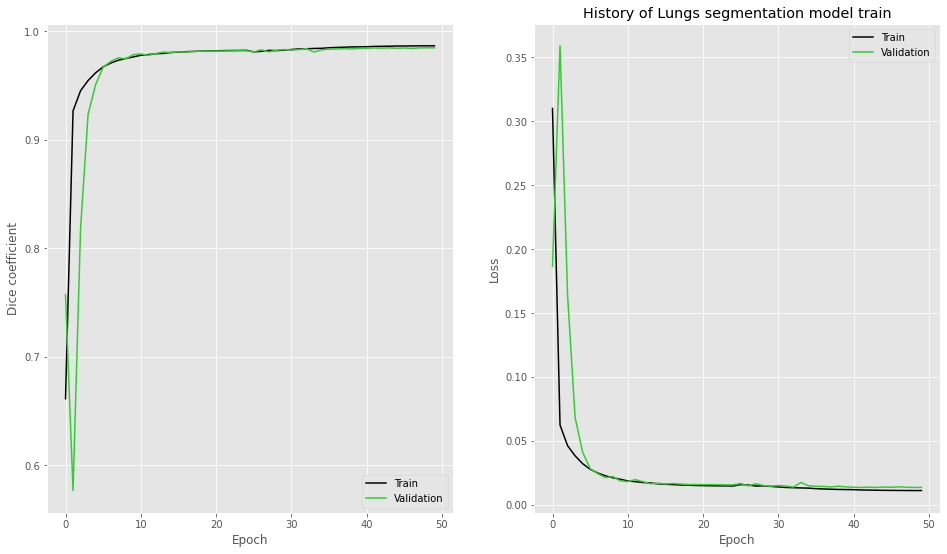

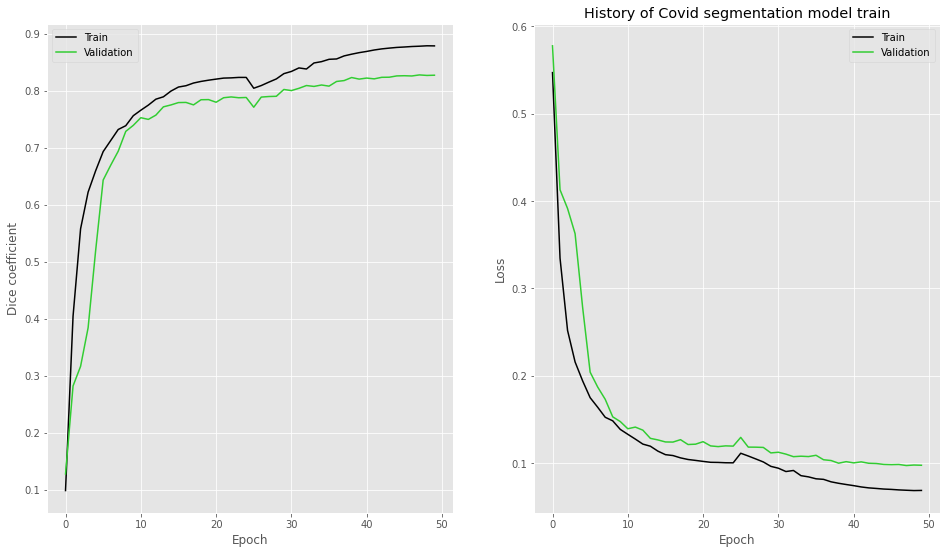

In [16]:
plot_history(lungs_history, 'History of Lungs segmentation model train')
plot_history(covid_history, 'History of Covid segmentation model train')

del BATCH_SIZE, EPOCHS, FROM_SCRATCH
del lungs_history, covid_history

# 7. Testing

[20, 133, 0, 131, 130]


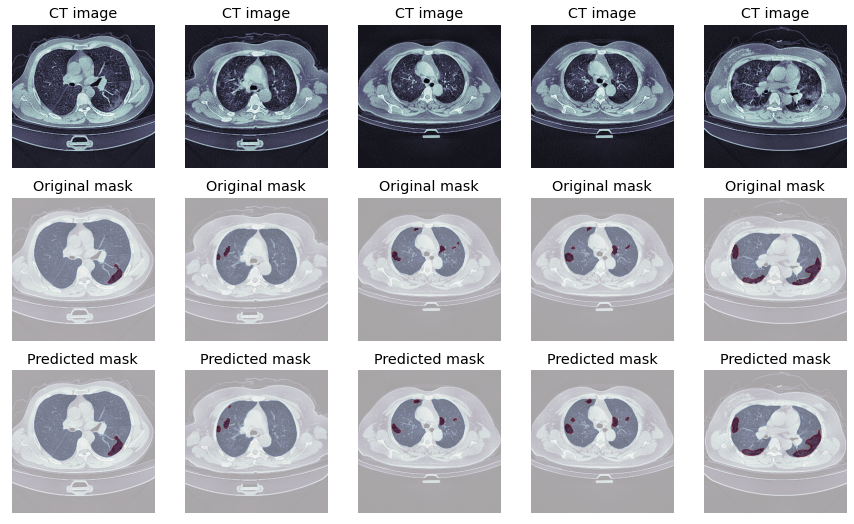

In [17]:
lungs_segmentation.load_weights(Const.LUNGS_MODEL_WEIGHTS_PATH)
covid_segmentation.load_weights(Const.COVID_MODEL_WEIGHTS_PATH)

lungs_prediction = lungs_segmentation.predict(test_x)
covid_prediction = covid_segmentation.predict(test_x)

indices = random.choices(range(len(test_x)), k=5)
_, axes = plt.subplots(3, 5, figsize=(15, 9))

print(indices)

for ii, idx in enumerate(indices):
    axes[0, ii].imshow(tf.squeeze(test_x[idx]), cmap='bone')
    axes[0, ii].set_title('CT image')
    axes[0, ii].set_xticks([])
    axes[0, ii].set_yticks([])
    plt.grid()

    axes[1, ii].imshow(tf.squeeze(test_x[idx]), cmap='bone')
    axes[1, ii].imshow(tf.squeeze(test_lungs[idx]), alpha=0.4, cmap='Blues')
    axes[1, ii].imshow(tf.squeeze(test_covid[idx]), alpha=0.4, cmap='Reds')
    axes[1, ii].set_title('Original mask')
    axes[1, ii].set_xticks([])
    axes[1, ii].set_yticks([])
    plt.grid()

    axes[2, ii].imshow(tf.squeeze(test_x[idx]), cmap='bone')
    axes[2, ii].imshow(tf.squeeze(lungs_prediction[idx]), alpha=0.4, cmap='Blues')
    axes[2, ii].imshow(tf.squeeze(covid_prediction[idx]), alpha=0.4, cmap='Reds')
    axes[2, ii].set_title('Predicted mask')
    axes[2, ii].set_xticks([])
    axes[2, ii].set_yticks([])
    plt.grid()

del lungs_segmentation, covid_segmentation
del indices, axes, ii, idx
del train_x, train_lungs, train_covid, valid_x, valid_lungs, valid_covid, test_lungs, test_covid

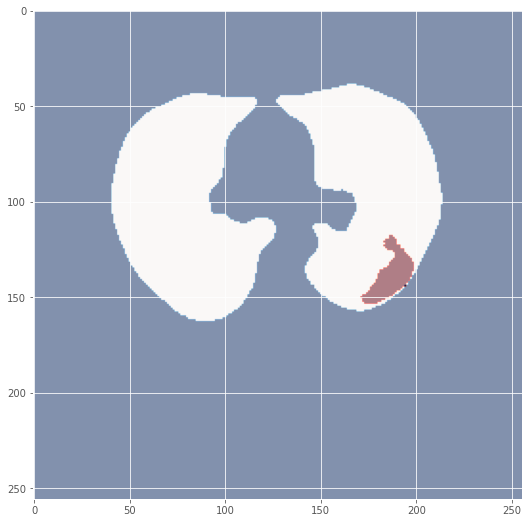

3.35%


In [18]:
ind = random.randint(0, len(test_x) - 1)

lungs_image = Preprocessor.binarize(lungs_prediction[ind].copy())
covid_image = Preprocessor.binarize(covid_prediction[ind].copy())

plt.figure(figsize=(9, 9))
plt.imshow(np.squeeze(lungs_image), cmap='Blues_r')
plt.imshow(np.squeeze(covid_image), alpha=0.5, cmap='Reds')
plt.show()

print(f'{Estimator.content(covid_prediction[ind], lungs_prediction[ind]):.2%}')

del ind, lungs_image, covid_image